### Edgar Moises Hernandez-Gonzalez
#### 09/04/20-20/04/20
#### Clasificacion de imagenes motoras en EEG con Fine Tuning
##### Caracteristicas = Escalogramas CWT (3D)
##### Concatenacion vertical
##### Data Augmentation

##### VGG16
##### Sujeto 1
##### Accuracy = 44.10%
##### Kappa = 0.2546

##### InceptionV3
##### Sujeto 1
##### Accuracy = 45.49%
##### Kappa = 0.2731

In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import cohen_kappa_score, confusion_matrix
import pywt
import cv2
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import InceptionV3
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense
from keras.optimizers import SGD
from keras import backend as K

Using TensorFlow backend.


In [ ]:
# para que este script funcione debe de decir 'channels_last', si dice 'channels_first' no sirve
K.image_data_format()

'channels_last'

In [ ]:
x_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01T.csv", header=None)
x_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/MI-EEG-A01E.csv", header=None)
y_train = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("/content/drive/My Drive/BCI-IV-2a/RAW/EtiquetasA01E.csv", header=None)

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 22000)
(288, 22000)
(288, 1)
(288, 1)


In [ ]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [ ]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [ ]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_label.py:268: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
# las etiquetas en categorical para poder entrenar data augmentation
y_train_categorical = to_categorical(y_train)
y_test_categorical = to_categorical(y_test)

In [ ]:
#unir 22 canales
def unir_escalogramas_vertical_resize(data):
  escalas = np.arange(1,129)
  dim = (299, 299) #ancho, alto
  datos = np.zeros((288,299,299,3))
  temporal = np.zeros((2816,1000,3))
  for i in range(data.shape[0]): #288 muestras
    for j in range(22): #22 canales
      sig = data.iloc[i, j*1000:(j+1)*1000]
      coef, freqs = pywt.cwt(sig, escalas, 'cmor3-3') #escalograma CWT
      x = abs(coef)
      temporal[j*128:(j+1)*128, :, 0] = x
      temporal[j*128:(j+1)*128, :, 1] = x
      temporal[j*128:(j+1)*128, :, 2] = x
    resized = cv2.resize(temporal, dim, interpolation=cv2.INTER_AREA)
    datos[i] = resized
    if i % 100 == 0: #esto solo es para ver como avanza
      print(i)
  return datos

In [ ]:
#llamar a escalogramas(data)
#primero x_train para no acabarse la RAM
x_train = unir_escalogramas_vertical_resize(x_train)

0
100
200


In [ ]:
#llamar a escalogramas(data)
#despues x_test para no acabarse la RAM
x_test = unir_escalogramas_vertical_resize(x_test)

0
100
200


In [ ]:
print(x_train.shape)
print(x_test.shape)

(288, 299, 299, 3)
(288, 299, 299, 3)


In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

66.0605704209217
58.92652956329641
0.002633029815965031
0.0028018946790724928
3.8612014821606695
3.7636597542096775


In [ ]:
#convertir a float
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

#escalar los valores en un rango de 0 a 1 (normalizar)
x_train /= 67.0
x_test /= 67.0

In [ ]:
print(np.max(x_train))
print(np.max(x_test))
print(np.min(x_train))
print(np.min(x_test))
print(np.mean(x_train))
print(np.mean(x_test))

0.98597866
0.87950045
3.9298953e-05
4.1819323e-05
0.05762994
0.056173973


In [ ]:
datagen_train = ImageDataGenerator(width_shift_range=0.25)

In [ ]:
base_model = InceptionV3(weights='imagenet',
                   include_top=False,
                   input_shape=x_train.shape[1:])

87916544/87910968 [==============================] - 7s 0us/step


In [ ]:
# operación global de agrupación máxima para datos espaciales.
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(n_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# entrenar solo las capas superiores (top) que se inicializaron aleatoriamente
# congelar todas las capas convolucionales de InceptionV3
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# debe hacerse después de configurar las capas como no entrenables
model.compile(optimizer = 'rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/40
 - 14s - loss: 2.1242 - accuracy: 0.2917 - val_loss: 1.4260 - val_accuracy: 0.2847
Epoch 2/40
 - 3s - loss: 1.4891 - accuracy: 0.3021 - val_loss: 1.4270 - val_accuracy: 0.2500
Epoch 3/40
 - 5s - loss: 1.4111 - accuracy: 0.3229 - val_loss: 1.4070 - val_accuracy: 0.2500
Epoch 4/40
 - 5s - loss: 1.3695 - accuracy: 0.3403 - val_loss: 1.4453 - val_accuracy: 0.2500
Epoch 5/40
 - 5s - loss: 1.3658 - accuracy: 0.3229 - val_loss: 1.4360 - val_accuracy: 0.2535
Epoch 6/40
 - 5s - loss: 1.3732 - accuracy: 0.3438 - val_loss: 1.3856 - val_accuracy: 0.2743
Epoch 7/40
 - 5s - loss: 1.3193 - accuracy: 0.3715 - val_loss: 1.4076 - val_accuracy: 0.2639
Epoch 8/40
 - 5s - loss: 1.3667 - accuracy: 0.3160 - val_loss: 1.3963 - val_accuracy: 0.2465
Epoch 9/40
 - 5s - loss: 1.2765 - accuracy: 0.3715 - val_loss: 1.4073 - val_accuracy: 0.2535
Epoch 10/40
 - 5s - loss: 1.3599 - accuracy: 0.3854 - val_loss: 1.4714 - val_accuracy: 0.2535
Epoch 11/40
 - 5s - loss: 1.2782 - accuracy: 0.4062 - v

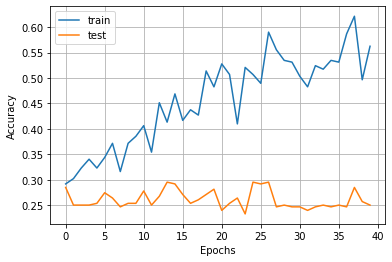

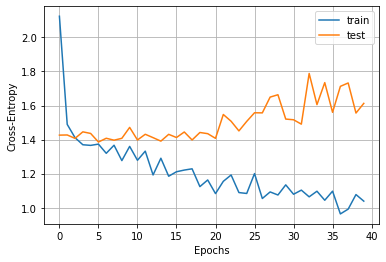


Resultados:
loss: [1.6124706268310547]
accuracy: [0.25]
kappa: [0.0]


In [ ]:
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=40,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
# en este punto las capas superiores (top) estan entrenadas
# podemos empezar a ajustar el fine tuning
# congelaremos n capas inferiores (bottom)
# entrenar las capas superiores (top) restantes
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [ ]:
# entrenar los 2 bloques de inicio principales
# congelaremos las primeras 249 capas y descongelaremos el resto
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

In [ ]:
# recompilar el modelo
model.compile(optimizer = SGD(lr=1e-6, momentum=0.9), #lr=0.0001, momentum=0.9
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

Iteration: 1
Epoch 1/400
 - 10s - loss: 0.8821 - accuracy: 0.6528 - val_loss: 1.6007 - val_accuracy: 0.2535
Epoch 2/400
 - 3s - loss: 0.9436 - accuracy: 0.6181 - val_loss: 1.5959 - val_accuracy: 0.2535
Epoch 3/400
 - 5s - loss: 0.9309 - accuracy: 0.6493 - val_loss: 1.5922 - val_accuracy: 0.2500
Epoch 4/400
 - 5s - loss: 0.9219 - accuracy: 0.6667 - val_loss: 1.5905 - val_accuracy: 0.2500
Epoch 5/400
 - 5s - loss: 0.9153 - accuracy: 0.6632 - val_loss: 1.5917 - val_accuracy: 0.2500
Epoch 6/400
 - 5s - loss: 0.9367 - accuracy: 0.6424 - val_loss: 1.5958 - val_accuracy: 0.2465
Epoch 7/400
 - 5s - loss: 0.9206 - accuracy: 0.6076 - val_loss: 1.5935 - val_accuracy: 0.2465
Epoch 8/400
 - 5s - loss: 0.8919 - accuracy: 0.6528 - val_loss: 1.5931 - val_accuracy: 0.2465
Epoch 9/400
 - 5s - loss: 0.9064 - accuracy: 0.6424 - val_loss: 1.5953 - val_accuracy: 0.2465
Epoch 10/400
 - 5s - loss: 0.8610 - accuracy: 0.6944 - val_loss: 1.5963 - val_accuracy: 0.2465
Epoch 11/400
 - 5s - loss: 0.8542 - accuracy:

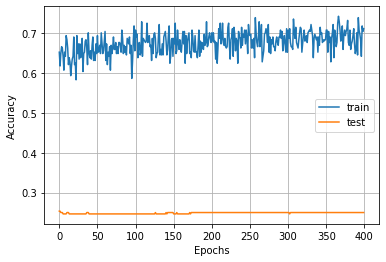

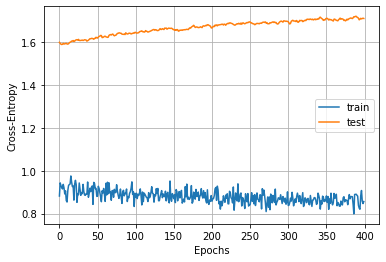


Resultados:
loss: [1.7122945520612929]
accuracy: [0.25]
kappa: [0.0]


In [ ]:
# entrenamos nuestro modelo nuevamente
# fine tuning a 2 bloques (top) superiores de inception
# y a las capas superiores (top)
array_loss = []
array_acc = []
array_kappa = []
for i in range(1):
  print("Iteration:", i+1)

  history = model.fit_generator(datagen_train.flow(x_train, y_train_categorical, batch_size=18),
                                steps_per_epoch=np.ceil(n_samples_train/18),
                                epochs=400,
                                validation_data=(x_test, y_test_categorical),
                                verbose=2)
    
  test_loss, test_acc = model.evaluate(x_test, y_test_categorical, verbose=0)
  array_loss.append(test_loss)
  print("loss: ", test_loss)
  array_acc.append(test_acc)
  print("accuracy: ", test_acc)
    
  probabilidades = model.predict(x_test)
  y_pred = np.argmax(probabilidades, 1) #1=fila
    
  kappa = cohen_kappa_score(y_test, y_pred)
  array_kappa.append(kappa)
  print("kappa: ", kappa)
    
  matriz_confusion = confusion_matrix(y_test, y_pred)
  print("confusion matrix:\n", matriz_confusion)
    
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'test'])
  plt.show()
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.grid()
  plt.xlabel('Epochs')
  plt.ylabel('Cross-Entropy')
  plt.legend(['train', 'test'])
  plt.show()
    
print() 
print("Resultados:")
print("loss:", array_loss)
print("accuracy:", array_acc)
print("kappa:", array_kappa)

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [ ]:
print("Mean Accuracy: %.4f" % np.mean(array_acc))
print("std: (+/- %.4f)" % np.std(array_acc))
print("Mean Kappa: %.4f" % np.mean(array_kappa))
print("std: (+/- %.4f)" % np.std(array_kappa))
print("Max Accuracy: %.4f" % np.max(array_acc))
print("Max Kappa: %.4f" % np.max(array_kappa))

Mean Accuracy: 0.2500
std: (+/- 0.0000)
Mean Kappa: 0.0000
std: (+/- 0.0000)
Max Accuracy: 0.2500
Max Kappa: 0.0000
